# Set Up the Environment

### Importing Libraries

In [ ]:

%pip install torchmetrics
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from datasets import load_dataset
import torchvision
from torchvision import transforms
from torchmetrics.image import StructuralSimilarityIndexMeasure
from transformers import AutoModelForDepthEstimation
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
import time
import PIL
from PIL import Image
import requests
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

### Mount Drive

In [2]:
from google.colab import drive

drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Define Needed Classes & Functions

### Class for Depth Model

In [3]:
class DepthModel(nn.Module):
    """
    Wrapper class for the Depth-Anything model.
    """
    def __init__(self, mod):
        super().__init__()
        self.model = mod
        self.eval()

    def forward(self, x):
        original_size = x.shape[2:]
        outputs = self.model(x)
        predicted_depth = outputs.predicted_depth
        # The shape is (batch, channel, height, width), so unpack accordingly
        # print(predicted_depth.shape) # Keep for debugging if needed

        # Ensure the tensor has 4 dimensions
        if predicted_depth.dim() == 3:
             predicted_depth = predicted_depth.unsqueeze(1) # Add a batch dimension if it's missing

        b, c, h, w = predicted_depth.shape
        predicted_depth_flat = predicted_depth.view(b, -1)
        # Find the max value for each image in the batch
        max_vals = predicted_depth_flat.max(dim=1, keepdim=True)[0]
        # Avoid division by zero
        max_vals[max_vals == 0] = 1.0
        # Normalize the teacher's depth map to [0, 1]
        predicted_depth_normalized = predicted_depth_flat / max_vals
        predicted_depth_normalized = predicted_depth_normalized.view(b, c, h, w) # Reshape back to original dimensions
        predicted_depth_normalized = F.interpolate(predicted_depth_normalized, size=original_size, mode='bilinear', align_corners=False)
        return predicted_depth_normalized

### Class for Student Model

In [4]:
class StudentModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Load pretrained MobileNetV3 as the encoder
        self.mobilenet_base = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT).features

        # It's better to unfreeze at least the last few layers of the encoder for fine-tuning.
        # Freezing the entire encoder can limit the model's learning capacity.
        # For now, we'll keep it as you had it.
        for param in self.mobilenet_base.parameters():
            param.requires_grad = False

        # --- Decoder with Skip Connections ---
        self.upconv1 = nn.ConvTranspose2d(960, 112, kernel_size=2, stride=2)
        self.d_conv1 = nn.Sequential(nn.Conv2d(112 + 112, 112, 3, padding=1), nn.ReLU())

        self.upconv2 = nn.ConvTranspose2d(112, 40, kernel_size=2, stride=2)
        self.d_conv2 = nn.Sequential(nn.Conv2d(40 + 40, 40, 3, padding=1), nn.ReLU())

        self.upconv3 = nn.ConvTranspose2d(40, 24, kernel_size=2, stride=2)
        self.d_conv3 = nn.Sequential(nn.Conv2d(24 + 24, 24, 3, padding=1), nn.ReLU())

        self.final_upsample = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(24, 16, 3, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(16, 1, 3, padding=1),
            nn.Sigmoid() # Sigmoid activation to output a normalized map [0, 1]
        )

    def forward(self, x):
        original_size = x.shape[2:]

        # --- Encoder Path ---
        s1 = self.mobilenet_base[0:4](x)
        s2 = self.mobilenet_base[4:7](s1)
        s3 = self.mobilenet_base[7:13](s2)
        s4 = self.mobilenet_base[13:](s3)

        # --- Decoder Path ---
        d1 = self.upconv1(s4)
        # Use interpolate to resize skip connection
        s3_resized = F.interpolate(s3, size=d1.shape[2:], mode='bilinear', align_corners=False)
        d1 = torch.cat([d1, s3_resized], dim=1)
        d1 = self.d_conv1(d1)

        d2 = self.upconv2(d1)
        # Use interpolate to resize skip connection
        s2_resized = F.interpolate(s2, size=d2.shape[2:], mode='bilinear', align_corners=False)
        d2 = torch.cat([d2, s2_resized], dim=1)
        d2 = self.d_conv2(d2)

        d3 = self.upconv3(d2)
        # Use interpolate to resize skip connection
        s1_resized = F.interpolate(s1, size=d3.shape[2:], mode='bilinear', align_corners=False)
        d3 = torch.cat([d3, s1_resized], dim=1)
        d3 = self.d_conv3(d3)

        # Final upsampling and interpolation to original size
        output = self.final_upsample(d3)
        # The final F.interpolate from your code can be removed if the student's
        # output size matches the input size, which it should with this architecture.
        # If there's a slight mismatch, it's fine to keep it.
        output = F.interpolate(output, size=original_size, mode='bilinear', align_corners=False)

        return output

### Class for Dataset Loading & Preprocessing

In [5]:
def custom_collate_fn(batch):
    """
    Custom collate function to handle images of different sizes.
    It returns a list of tensors, where each tensor corresponds to an image.
    """
    return batch

In [6]:
class UnlabeledImageDataset(Dataset):
    """
    Custom dataset for unlabeled images.
    """
    def __init__(self, root_dir, transform=None, resize_size=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(('png', 'jpg', 'JPG'))]
        self.resize_size = resize_size
        print(f"Found {len(self.image_paths)} images in {root_dir}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.resize_size:
            image = image.resize(self.resize_size)

        if self.transform:
            image = self.transform(image)


        return image

### Distillation Loss

In [7]:
class DepthCombinedDistillationLoss(nn.Module):
    """
    Custom loss function for depth distillation.
    Using Pixel wise MSE Loss, SSIM, Gradient MAE Loss, and Scale-Invariant MSE Loss.
    """
    def __init__(self, lambda_depth=1.0, lambda_si=1.0, lambda_grad=1.0, lambda_ssim=1.0, lambda_smooth=0.2):
        super().__init__()
        self.lambda_depth = lambda_depth   # Weight for depth map MSE loss
        self.lambda_si = lambda_si         # Weight for Scale-Invariant MSE loss
        self.lambda_grad = lambda_grad     # Weight for Gradient loss
        self.lambda_ssim = lambda_ssim     # Weight for SSIM loss
        self.lambda_smooth = lambda_smooth # Weight for smoothness regularizer

        self.mse_depth_loss = nn.MSELoss()  # Mean Squared Error for depth maps
        self.l1_loss = nn.L1Loss()          # L1 Loss for gradients

        # Initialize the SSIM calculation from torchmetrics
        if self.lambda_ssim > 0:
            self.ssim = StructuralSimilarityIndexMeasure(data_range=1.0)

    def forward(self, student_outputs, teacher_outputs):
        student_depth = student_outputs
        teacher_depth = teacher_outputs

        # Ensure tensors have a batch dimension if they don't (e.g., single image)
        if student_depth.dim() == 3:
            student_depth = student_depth.unsqueeze(0)
        if teacher_depth.dim() == 3:
            teacher_depth = teacher_depth.unsqueeze(0)

        # Ensure tensors have a channel dimension if they don't (e.g., grayscale depth map)
        if student_depth.dim() == 3: # Assuming (Batch, Height, Width)
             student_depth = student_depth.unsqueeze(1) # Becomes (Batch, Channel, Height, Width)
        if teacher_depth.dim() == 3: # Assuming (Batch, Height, Width)
             teacher_depth = teacher_depth.unsqueeze(1) # Becomes (Batch, Channel, Height, Width)

        total_loss = torch.tensor(0.0, device=student_depth.device)

        # 1. MSE Depth Loss
        if self.lambda_depth > 0:
            loss_depth = self.mse_depth_loss(student_depth, teacher_depth)
            total_loss += self.lambda_depth * loss_depth

        # 2. Scale-Invariant MSE Loss
        if self.lambda_si > 0:
            diff = student_depth - teacher_depth
            loss_si = torch.mean(diff**2) - torch.mean(diff)**2
            total_loss += self.lambda_si * loss_si

        # 3. Gradient Loss (using L1 on gradients)
        if self.lambda_grad > 0:
            # Calculate gradients along x and y dimensions
            student_grad_x = torch.abs(student_depth[:, :, :, :-1] - student_depth[:, :, :, 1:])
            student_grad_y = torch.abs(student_depth[:, :, :-1, :] - student_depth[:, :, 1:, :])
            teacher_grad_x = torch.abs(teacher_depth[:, :, :, :-1] - teacher_depth[:, :, :, 1:])
            teacher_grad_y = torch.abs(teacher_depth[:, :, :-1, :] - teacher_depth[:, :, 1:, :])

            loss_grad = self.l1_loss(student_grad_x, teacher_grad_x) + self.l1_loss(student_grad_y, teacher_grad_y)
            total_loss += self.lambda_grad * loss_grad

        # 4.Smoothness Loss (Regularizer)
        if self.lambda_smooth > 0:
            # Penalizes the L1 norm of the student's depth gradients
            student_grad_x_smooth = torch.abs(student_depth[:, :, :, :-1] - student_depth[:, :, :, 1:])
            student_grad_y_smooth = torch.abs(student_depth[:, :, :-1, :] - student_depth[:, :, 1:, :])
            loss_smooth = torch.mean(student_grad_x_smooth) + torch.mean(student_grad_y_smooth)
            total_loss += self.lambda_smooth * loss_smooth

        # 5. SSIM Loss
        if self.lambda_ssim > 0:
            # Move ssim module to the same device as the tensors
            self.ssim.to(student_depth.device)

            # The torchmetrics SSIM implementation returns a value between -1 and 1.
            # A value of 1 indicates perfect similarity.
            # To use it as a loss, we subtract it from 1.
            # SSIM expects input tensors to have shape (N, C, H, W)
            d_ssim = self.ssim(student_depth, teacher_depth)
            loss_ssim = (1 - d_ssim) / 2 # Normalize to be between 0 and 1
            total_loss += self.lambda_ssim * loss_ssim

        return total_loss

### The Training Function

In [8]:
def train_knowledge_distillation(teacher, student, train_dataloader, val_dataloader, criterion, optimizer, epochs, device):
    """
    Train the student model using Response-Based knowledge distillation.
    """
    teacher.eval() # Teacher should always be in evaluation mode

    print(f"Starting Knowledge Distillation Training on {device}...")
    min_loss = float('inf')
    for epoch in range(epochs):
        student.train() # Student in training mode
        running_loss = 0.0
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
        start_time = time.time()

        for images in progress_bar:
            # images is a list of tensors due to custom_collate_fn
            # Move each image tensor in the list to the device
            images = [img.to(device) for img in images]

            optimizer.zero_grad()

            # Forward pass with Teacher model (no_grad as teacher is fixed)
            with torch.no_grad():
                # Process each image individually through the teacher model
                teacher_outputs = [teacher(img.unsqueeze(0)) for img in images] # Returns depth map for each image

            # Forward pass with Student model
            # Process each image individually through the student model
            student_outputs = [student(img.unsqueeze(0)) for img in images] # Returns depth map for each image


            # Calculate distillation loss for each image and sum them
            loss = sum(criterion(student_output, teacher_output) for student_output, teacher_output in zip(student_outputs, teacher_outputs))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()


        epoch_loss = running_loss / len(train_dataloader)
        current_lr = scheduler.get_last_lr()[0]
        end_time = time.time()
        print(f"End of Epoch {epoch+1},Time: {end_time - start_time:.2f}s, Current LR: {current_lr:.6f}, Average Loss: {epoch_loss:.4f}")
        scheduler.step()

        # Validation loop
        student.eval() # Student in evaluation mode for validation
        val_running_loss = 0.0
        with torch.no_grad():
            progress_bar_val = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Validation]")
            for val_images in progress_bar_val:
                # val_images is a list of tensors
                val_images = [img.to(device) for img in val_images]

                # Process each image individually through the teacher and student models
                teacher_outputs = [teacher(img.unsqueeze(0)) for img in val_images]
                student_outputs = [student(img.unsqueeze(0)) for img in val_images]

                # Calculate validation loss
                val_loss = sum(criterion(student_output, teacher_output) for student_output, teacher_output in zip(student_outputs, teacher_outputs))
                val_running_loss += val_loss.item()

        val_epoch_loss = val_running_loss / len(val_dataloader)
        print(f"Average Validation Loss: {val_epoch_loss:.4f}")

        if val_epoch_loss < min_loss:
            min_loss = val_epoch_loss
            print("Validation loss improved. Saving the model.")
            torch.save(student.state_dict(), f"/content/drive/MyDrive/best_Skip_student.pth")

    print("Knowledge Distillation Training Finished!")

# Training Process

### Define Parameters & Models

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load teacher model
teacher = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Large-hf").to(device)


teacher_model = DepthModel(teacher).to(device)

# student  model architecture
student_model = StudentModel().to(device)

######################################################
# Load the entire model object from the checkpoint
# student_model = torch.load('/content/drive/MyDrive/distillSkip1700.pth', weights_only=False).to(device)

###########################
# Initialize optimizer for the student model
# student_optimizer = optim.Adam(student_model.parameters(), lr=1e-4)
student_optimizer = optim.AdamW(student_model.parameters(), lr=1e-4, weight_decay=1e-4)

# Training parameters
num_epochs = 60
# scheduler = CosineAnnealingLR(student_optimizer, T_max=num_epochs, eta_min=1e-5ss)
scheduler = StepLR(student_optimizer, step_size=20, gamma=0.9)
# Distillation Loss
# Instantiate the custom loss function
distillation_criterion = DepthCombinedDistillationLoss(lambda_depth=1.0,  lambda_si=0.6, lambda_grad=0.7, lambda_ssim=0.9)

# transformations for input images (teacher and student will use the same)

input_size = (384, 384)

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Specify the path to your unlabeled data in Google Drive
unlabeled_data_path = '/content/drive/MyDrive/images/'

# Create two separate datasets with their respective transforms
train_full_dataset = UnlabeledImageDataset(root_dir=unlabeled_data_path, transform=transform, resize_size=input_size)
val_full_dataset = UnlabeledImageDataset(root_dir=unlabeled_data_path, transform=eval_transform, resize_size=input_size)

# Use the same indices to split both datasets
dataset_size = len(train_full_dataset)
train_size = int(0.7 * dataset_size)
val_size = dataset_size - train_size

indices = list(range(dataset_size))
np.random.shuffle(indices) # a random seed might be useful here: np.random.seed(42)
train_indices, val_indices = indices[:train_size], indices[train_size:]

# Create subsets for training and validation
train_dataset = torch.utils.data.Subset(train_full_dataset, train_indices)
val_dataset = torch.utils.data.Subset(val_full_dataset, val_indices)


# Create separate dataloaders for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=2)#, collate_fn=custom_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)#, collate_fn=custom_collate_fn)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Found 152 images in /content/drive/MyDrive/images/
Found 152 images in /content/drive/MyDrive/images/
Training set size: 106
Validation set size: 46


Before Training

In [10]:
# Load train image
image_path = "/content/drive/MyDrive/images/image1.JPG"
train_image = cv2.imread(image_path)
train_image = cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB)  # Convert to RGB

train_input_tensor = eval_transform(Image.fromarray(train_image)).unsqueeze(0).to(device)
# Load image
image_path = "/content/test.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

input_tensor = eval_transform(Image.fromarray(image)).unsqueeze(0).to(device)

student_model.eval() # Use the DepthModel instance


with torch.no_grad():
    # Student prediction (before training) using the DepthModel instance
    student_depth_before = student_model(input_tensor)
    student_depth_before_training = student_depth_before.squeeze().cpu().numpy()
    student_depth_before = student_model(train_input_tensor)
    student_depth_before_training_train_image = student_depth_before.squeeze().cpu().numpy()


### Freeze Student's Encoder

In [11]:

# Calculate and print the number of parameters
total_params = 0
for name, param in student_model.named_parameters():
    if not param.requires_grad:
        # print(f"Layer: {name}, Trainable Parameters: {param.numel()}")
      total_params += param.numel()

print(f"------------------------------------------")
print(f"Total Parameters: {total_params}")

# --- Verify which layers are trainable ---
print("All parameters in student_model:")
for name, param in student_model.named_parameters():
    if param.requires_grad:
        print(f"  {name}")



------------------------------------------
Total Parameters: 2971952
All parameters in student_model:
  upconv1.weight
  upconv1.bias
  d_conv1.0.weight
  d_conv1.0.bias
  upconv2.weight
  upconv2.bias
  d_conv2.0.weight
  d_conv2.0.bias
  upconv3.weight
  upconv3.bias
  d_conv3.0.weight
  d_conv3.0.bias
  final_upsample.1.weight
  final_upsample.1.bias
  final_upsample.4.weight
  final_upsample.4.bias


### Run the Training

In [14]:
    # Run the training
train_knowledge_distillation(
    teacher=teacher_model,
    student=student_model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    criterion=distillation_criterion,
    optimizer=student_optimizer,
    epochs=num_epochs,
    device=device
)

print("Training complete. Student model saved at specified checkpoints.")


Starting Knowledge Distillation Training on cuda...


Epoch 1/60: 100%|██████████| 11/11 [00:38<00:00,  3.48s/it]


End of Epoch 1,Time: 38.32s, Current LR: 0.000100, Average Loss: 2.9722


Epoch 1/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.24s/it]


Average Validation Loss: 1.1845
Validation loss improved. Saving the model.


Epoch 2/60: 100%|██████████| 11/11 [00:36<00:00,  3.36s/it]


End of Epoch 2,Time: 36.99s, Current LR: 0.000100, Average Loss: 2.8919


Epoch 2/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.23s/it]


Average Validation Loss: 1.1621
Validation loss improved. Saving the model.


Epoch 3/60: 100%|██████████| 11/11 [00:37<00:00,  3.45s/it]


End of Epoch 3,Time: 38.00s, Current LR: 0.000100, Average Loss: 2.8583


Epoch 3/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.16s/it]


Average Validation Loss: 1.1359
Validation loss improved. Saving the model.


Epoch 4/60: 100%|██████████| 11/11 [00:40<00:00,  3.64s/it]


End of Epoch 4,Time: 40.01s, Current LR: 0.000100, Average Loss: 2.8208


Epoch 4/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.19s/it]


Average Validation Loss: 1.1187
Validation loss improved. Saving the model.


Epoch 5/60: 100%|██████████| 11/11 [00:37<00:00,  3.41s/it]


End of Epoch 5,Time: 37.47s, Current LR: 0.000100, Average Loss: 2.7709


Epoch 5/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.24s/it]


Average Validation Loss: 1.1311


Epoch 6/60: 100%|██████████| 11/11 [00:39<00:00,  3.62s/it]


End of Epoch 6,Time: 39.86s, Current LR: 0.000100, Average Loss: 2.7433


Epoch 6/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.24s/it]


Average Validation Loss: 1.0943
Validation loss improved. Saving the model.


Epoch 7/60: 100%|██████████| 11/11 [00:38<00:00,  3.47s/it]


End of Epoch 7,Time: 38.18s, Current LR: 0.000100, Average Loss: 2.6903


Epoch 7/60 [Validation]: 100%|██████████| 12/12 [00:15<00:00,  1.28s/it]


Average Validation Loss: 1.1117


Epoch 8/60: 100%|██████████| 11/11 [00:35<00:00,  3.26s/it]


End of Epoch 8,Time: 35.90s, Current LR: 0.000100, Average Loss: 2.6541


Epoch 8/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.16s/it]


Average Validation Loss: 1.0967


Epoch 9/60: 100%|██████████| 11/11 [00:37<00:00,  3.38s/it]


End of Epoch 9,Time: 37.17s, Current LR: 0.000100, Average Loss: 2.6222


Epoch 9/60 [Validation]: 100%|██████████| 12/12 [00:15<00:00,  1.25s/it]


Average Validation Loss: 1.0874
Validation loss improved. Saving the model.


Epoch 10/60: 100%|██████████| 11/11 [00:37<00:00,  3.38s/it]


End of Epoch 10,Time: 37.18s, Current LR: 0.000100, Average Loss: 2.6254


Epoch 10/60 [Validation]: 100%|██████████| 12/12 [00:15<00:00,  1.25s/it]


Average Validation Loss: 1.0963


Epoch 11/60: 100%|██████████| 11/11 [00:37<00:00,  3.44s/it]


End of Epoch 11,Time: 37.85s, Current LR: 0.000090, Average Loss: 2.5828


Epoch 11/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.16s/it]


Average Validation Loss: 1.0983


Epoch 12/60: 100%|██████████| 11/11 [00:37<00:00,  3.41s/it]


End of Epoch 12,Time: 37.50s, Current LR: 0.000090, Average Loss: 2.5984


Epoch 12/60 [Validation]: 100%|██████████| 12/12 [00:15<00:00,  1.25s/it]


Average Validation Loss: 1.0960


Epoch 13/60: 100%|██████████| 11/11 [00:37<00:00,  3.38s/it]


End of Epoch 13,Time: 37.14s, Current LR: 0.000090, Average Loss: 2.5387


Epoch 13/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.24s/it]


Average Validation Loss: 1.0814
Validation loss improved. Saving the model.


Epoch 14/60: 100%|██████████| 11/11 [00:38<00:00,  3.50s/it]


End of Epoch 14,Time: 38.47s, Current LR: 0.000090, Average Loss: 2.5509


Epoch 14/60 [Validation]: 100%|██████████| 12/12 [00:15<00:00,  1.32s/it]


Average Validation Loss: 1.1006


Epoch 15/60:  18%|█▊        | 2/11 [00:08<00:38,  4.29s/it]


KeyboardInterrupt: 

Starting Knowledge Distillation Training on cuda...

Epoch 1/60: 100%|██████████| 11/11 [00:38<00:00,  3.46s/it]

End of Epoch 1,Time: 38.09s, Current LR: 0.000100, Average Loss: 4.3529

Epoch 1/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.25s/it]

Average Validation Loss: 1.6780

Validation loss improved. Saving the model.

Epoch 2/60: 100%|██████████| 11/11 [00:37<00:00,  3.39s/it]

End of Epoch 2,Time: 37.28s, Current LR: 0.000100, Average Loss: 4.0577

Epoch 2/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.16s/it]

Average Validation Loss: 1.5865

Validation loss improved. Saving the model.

Epoch 3/60: 100%|██████████| 11/11 [00:36<00:00,  3.35s/it]

End of Epoch 3,Time: 36.88s, Current LR: 0.000100, Average Loss: 3.8247

Epoch 3/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.24s/it]

Average Validation Loss: 1.5265

Validation loss improved. Saving the model.

Epoch 4/60: 100%|██████████| 11/11 [00:38<00:00,  3.46s/it]

End of Epoch 4,Time: 38.03s, Current LR: 0.000100, Average Loss: 3.6837

Epoch 4/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.24s/it]

Average Validation Loss: 1.4827

Validation loss improved. Saving the model.

Epoch 5/60: 100%|██████████| 11/11 [00:39<00:00,  3.60s/it]

End of Epoch 5,Time: 39.62s, Current LR: 0.000100, Average Loss: 3.5865

Epoch 5/60 [Validation]: 100%|██████████| 12/12 [00:15<00:00,  1.27s/it]

Average Validation Loss: 1.4467

Validation loss improved. Saving the model.

Epoch 6/60: 100%|██████████| 11/11 [00:36<00:00,  3.30s/it]

End of Epoch 6,Time: 36.26s, Current LR: 0.000100, Average Loss: 3.5146

Epoch 6/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.14s/it]

Average Validation Loss: 1.4140

Validation loss improved. Saving the model.

Epoch 7/60: 100%|██████████| 11/11 [00:40<00:00,  3.67s/it]

End of Epoch 7,Time: 40.33s, Current LR: 0.000100, Average Loss: 3.4348

Epoch 7/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.20s/it]

Average Validation Loss: 1.3800

Validation loss improved. Saving the model.

Epoch 8/60: 100%|██████████| 11/11 [00:37<00:00,  3.37s/it]

End of Epoch 8,Time: 37.12s, Current LR: 0.000100, Average Loss: 3.3191

Epoch 8/60 [Validation]: 100%|██████████| 12/12 [00:15<00:00,  1.26s/it]

Average Validation Loss: 1.3404

Validation loss improved. Saving the model.

Epoch 9/60: 100%|██████████| 11/11 [00:37<00:00,  3.44s/it]

End of Epoch 9,Time: 37.80s, Current LR: 0.000100, Average Loss: 3.2374

Epoch 9/60 [Validation]: 100%|██████████| 12/12 [00:15<00:00,  1.26s/it]

Average Validation Loss: 1.2820

Validation loss improved. Saving the model.

Epoch 10/60: 100%|██████████| 11/11 [00:38<00:00,  3.53s/it]

End of Epoch 10,Time: 38.79s, Current LR: 0.000100, Average Loss: 3.1101

Epoch 10/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.12s/it]

Average Validation Loss: 1.2205

Validation loss improved. Saving the model.

# Evaluation

### On training

✅ Student model inference time: 9.63 ms


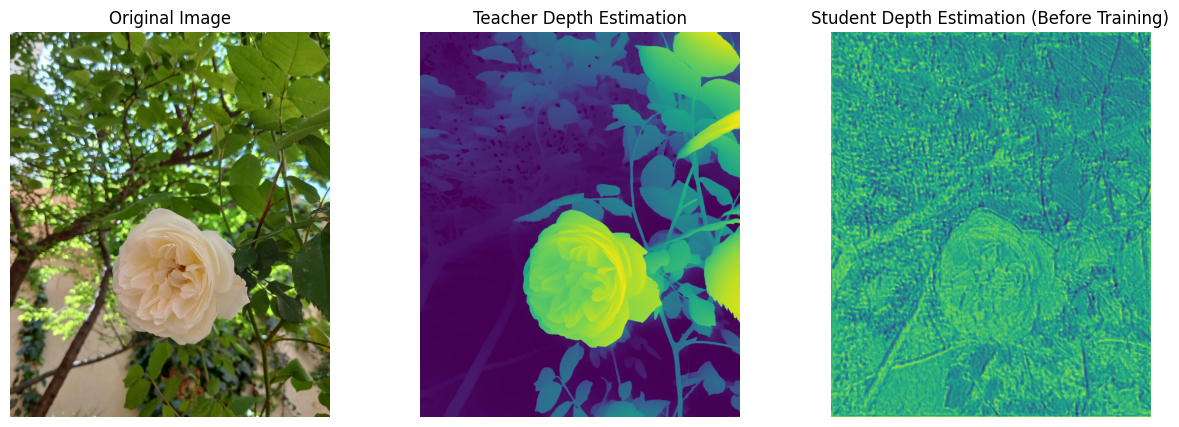

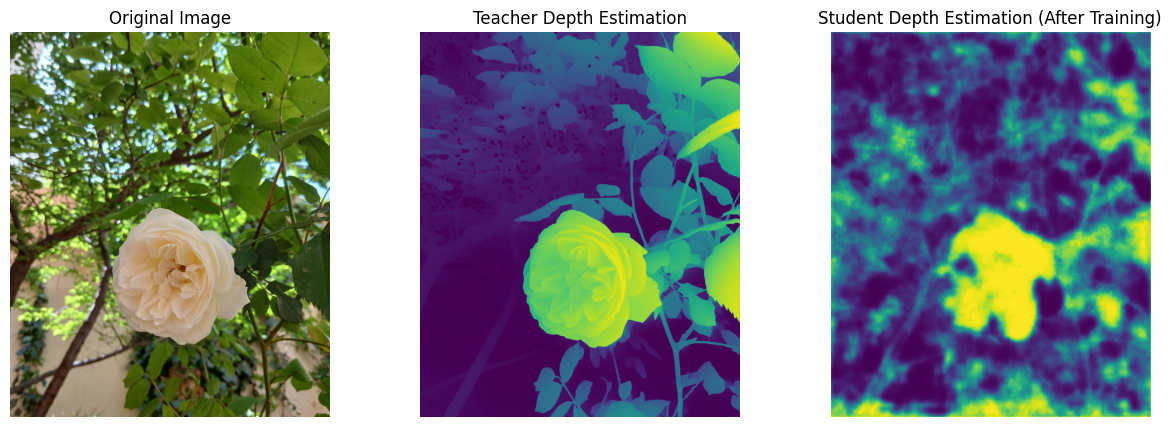

In [15]:
# Load image
image_path = "/content/drive/MyDrive/images/image1.JPG"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

input_tensor = eval_transform(Image.fromarray(image)).unsqueeze(0).to(device)

# Set models to evaluation mode
teacher_model.eval() # Use the DepthModel instance
student_model.eval() # Use the DepthModel instance


with torch.no_grad():
    # Student prediction (before training) using the DepthModel instance
    start_time = time.time()
    student_output_after = student_model(input_tensor)
    end_time = time.time()
    inference_time_ms = (end_time - start_time) * 1000
    print(f"✅ Student model inference time: {inference_time_ms:.2f} ms")

    student_output_after_training = student_output_after.squeeze().cpu().numpy()

    # Teacher prediction using the DepthModel instance
    teacher_depth = teacher_model(input_tensor)
    teacher_depth_to_plot = teacher_depth.squeeze().cpu().numpy() # Squeeze only for plotting

# loss = distillation_criterion(student_output_after_training, teacher_depth)
# print(loss.item())
#Befor training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth_to_plot, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_depth_before_training_train_image, cmap="viridis")
plt.title("Student Depth Estimation (Before Training)")
plt.axis("off")

plt.show()

#After training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth_to_plot, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_output_after_training, cmap="viridis")
plt.title("Student Depth Estimation (After Training)")
plt.axis("off")

plt.show()

### On Testing

0.18369102478027344


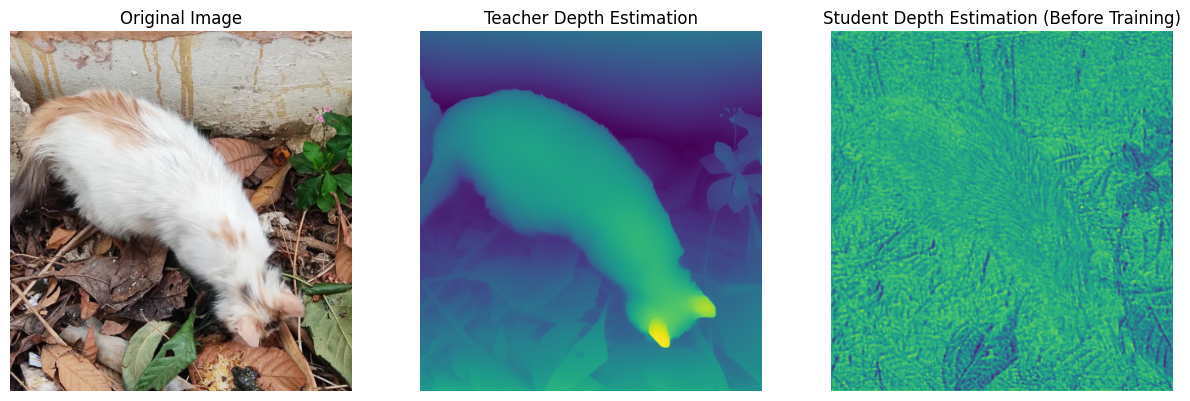

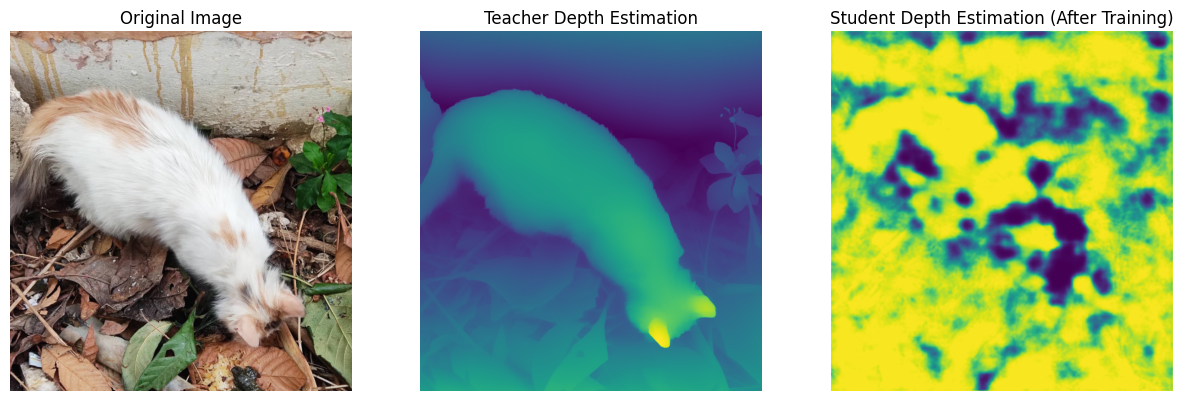

In [16]:
# Load image
image_path = "/content/test.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

input_tensor = eval_transform(Image.fromarray(image)).unsqueeze(0).to(device)

# Set models to evaluation mode
teacher_model.eval() # Use the DepthModel instance
student_model.eval() # Use the DepthModel instance

loss = 0;
with torch.no_grad():
    # Student prediction (before training) using the DepthModel instance
    student_output_after = student_model(input_tensor)
    student_output_after_training = student_output_after.squeeze().cpu().numpy()

    # Teacher prediction using the DepthModel instance
    teacher_depth = teacher_model(input_tensor)


    loss = distillation_criterion(student_output_after, teacher_depth)
    teacher_depth_to_plot = teacher_depth.squeeze().cpu().numpy()

print(loss.item())
#Befor training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth_to_plot, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_depth_before_training, cmap="viridis")
plt.title("Student Depth Estimation (Before Training)")
plt.axis("off")

plt.show()

#After training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth_to_plot, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_output_after_training, cmap="viridis")
plt.title("Student Depth Estimation (After Training)")
plt.axis("off")

plt.show()

### Saving a CheckPoint

In [ ]:
torch.save(student_model, "/content/drive/MyDrive/distillSkipL2500.pth")

In [ ]:
# student  model architecture
best_student_model = StudentModel().to(device)

######################################################
# Load the entire model object from the checkpoint
best_student_model.load_state_dict(torch.load('/content/drive/MyDrive/best_Skip_student.pth', weights_only=True))


best_student_model.eval()


In [ ]:
# Load image
image_path = "/content/drive/MyDrive/images/image1.JPG"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

input_tensor = eval_transform(Image.fromarray(image)).unsqueeze(0).to(device)

# Set models to evaluation mode
teacher_model.eval() # Use the DepthModel instance
# best_student_model.eval() # Use the DepthModel instance


with torch.no_grad():
    # Student prediction (before training) using the DepthModel instance
    start_time = time.time()
    student_output_after = best_student_model(input_tensor)
    end_time = time.time()
    inference_time_ms = (end_time - start_time) * 1000
    print(f"✅ Student model inference time: {inference_time_ms:.2f} ms")

    student_output_after_training = student_output_after.squeeze().cpu().numpy()

    # Teacher prediction using the DepthModel instance
    teacher_depth = teacher_model(input_tensor)
    teacher_depth = teacher_depth.squeeze().cpu().numpy()

# loss = distillation_criterion(student_output_after_training, teacher_depth)
# print(loss.item())
#Befor training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_depth_before_training_train_image, cmap="viridis")
plt.title("Student Depth Estimation (Before Training)")
plt.axis("off")

plt.show()

#After training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_output_after_training, cmap="viridis")
plt.title("Student Depth Estimation (After Training)")
plt.axis("off")

plt.show()



In [ ]:
# Load image
image_path = "/content/test.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

input_tensor = eval_transform(Image.fromarray(image)).unsqueeze(0).to(device)

# Set models to evaluation mode
teacher_model.eval() # Use the DepthModel instance
best_student_model.eval() # Use the DepthModel instance

loss = 0;
with torch.no_grad():
    # Student prediction (before training) using the DepthModel instance
    student_output_after = best_student_model(input_tensor)
    student_output_after_training = student_output_after.squeeze().cpu().numpy()

    # Teacher prediction using the DepthModel instance
    teacher_depth = teacher_model(input_tensor)
    loss = distillation_criterion(student_output_after, teacher_depth)
    teacher_depth = teacher_depth.squeeze().cpu().numpy()

print(loss.item())
#Befor training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_depth_before_training, cmap="viridis")
plt.title("Student Depth Estimation (Before Training)")
plt.axis("off")

plt.show()

#After training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_output_after_training, cmap="viridis")
plt.title("Student Depth Estimation (After Training)")
plt.axis("off")

plt.show()